In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [57]:
import cv2
import os

In [111]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('/Downloads/mnists', one_hot='True')

Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /Downloads/mnists\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /Downloads/mnists\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /Downloads/mnists\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /Downloads/mnists\t10k-labels-idx1-ubyte.gz


In [112]:
filter_1 = 5
channels_1 = 16

filter_2 = 5
channels_2 = 36

fc_size = 128

In [113]:
saver = tf.train.Saver()

In [114]:
y_true_test_cls = np.argmax(data.test.labels, axis = 1)

In [115]:
save_path = 'weights_biases/CNN_mnist'

In [116]:
imgsize = 28*28
input_channels = 1
num_classes = 10

In [117]:
data.test.cls = np.argmax(data.test.labels, axis=1)
data.validation.cls = np.argmax(data.validation.labels, axis=1)

In [76]:
def plot_image(images, cls_true, cls_pred = None):
    fig, axes = plt.subplots(1,2)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    for i,ax in enumerate(axes.flat):
        if cls_pred is not None:
            xlabel = 'True:{0} and Pred:{1}'.format(cls_true[i], cls_pred[i])
        else:
            xlabel = 'True:{0} '.format(cls_true[i])
        ax.imshow(images[i].reshape(28, 28), cmap='binary')
        ax.set_xlabel(xlabel)


(784,)


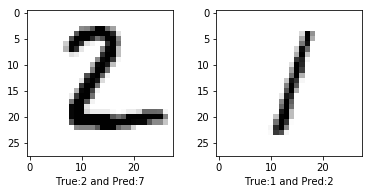

In [118]:
image_test = data.test.images[1:3]
cls_true = y_true_test_cls[1:3]
pred = np.array([7,2])
plot_image(images=image_test, cls_true=cls_true, cls_pred=pred)
print(image_test[0].shape)

In [78]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.05))
def new_biases(biaslength):
    return tf.Variable(tf.constant(0.05, shape=[biaslength]))

In [79]:
def new_conv_layer(input_image,
              num_channels,#number of channels in the previous layer output(Ex:16)
              filter_size,#usually 5x5
              num_filters,#number of channels coming out of this layer(Ex:36)
              pooling = True):
    shape = [filter_size, filter_size, num_channels, num_filters]
    weights = new_weights(shape)
    biases = new_biases(biaslength = num_filters)
    
    layer = tf.nn.conv2d(input = input_image,
                        filter = weights,
                        strides = [1,1,1,1],#input_imgae_number, x_axis, y_Axis, channels in use.change only middle two
                        padding = 'SAME')
    layer += biases
    
    if pooling:
        layer = tf.nn.max_pool(value = layer,
                              ksize = [1,2,2,1],#Size of window to be considered(window from which we pick the max value)
                              strides = [1,2,2,1],#Usually the same as the window size
                              padding = 'SAME')
    layer = tf.nn.relu(layer)
    
    return layer, weights

In [80]:
def flatten_layer(layer):
    #Usually the conv layer returns a 4 dim data, we need to flatten to 2 dim before giving it to FC layer.
    layer_shape = layer.shape
    #Expected: [num_images, img_width, imag_height, num_channels]
    num_features = np.array(layer_shape[1:4], dtype=int).prod()
    #transform to 2dim, [num_images, num_features]
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [81]:
#We are expecting the input to be a 2 dimensional data.[num_images, num_inputs==num_features].
#Output will be again a 2 dim[num_images, num_outputs]
def fully_connected_layer(images,#input from previous layer
                         num_inputs,
                         num_outputs,
                         relu = True):
    weights = new_weights(shape = [num_inputs, num_outputs])
    biases = new_biases(biaslength = num_outputs)
    
    layer = tf.matmul(images, weights) + biases
    
    if relu:
        layer = tf.nn.relu(layer)
    
    return layer

In [82]:
x = tf.placeholder(tf.float32, shape=[None, imgsize], name='x')
#We are going to be givign the entire image data to this variable. meaning num_images X all pixels.
x_image = tf.reshape(x, [-1, 28, 28, input_channels])
#For feeding into the conv layer. [num_images, image_x_size, image_y_size, num_of_channels]
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
#[num_images, num_classes]
y_true_cls = tf.argmax(y_true, dimension=1)

In [83]:
layer_1, weights_1 = new_conv_layer(input_image = x_image,
                                      num_channels = input_channels,#number of channels in the previous layer output(Ex:16)
                                      filter_size = filter_1,#usually 5x5
                                      num_filters = channels_1,#number of channels coming out of this layer(Ex:36)
                                      pooling = True)
#We are actually providing all the images at once here. To understand see that x_image is of [num_images, 28, 28, 1=gray_image]


In [85]:
weights_1

<tf.Variable 'Variable_8:0' shape=(5, 5, 1, 16) dtype=float32_ref>

In [86]:
layer_2, weights_2 = new_conv_layer(input_image = layer_1,#This is ok, becasue we are providing conv layer with 4 dim data
                                      num_channels = channels_1,#number of channels in the previous layer output(Ex:16)
                                      filter_size = filter_2,#usually 5x5
                                      num_filters = channels_2,#number of channels coming out of this layer(Ex:36)
                                      pooling = True)

In [87]:
layer_2

<tf.Tensor 'Relu_4:0' shape=(?, 7, 7, 36) dtype=float32>

In [88]:
weights_2

<tf.Variable 'Variable_10:0' shape=(5, 5, 16, 36) dtype=float32_ref>

In [89]:
layer_flat, num_features = flatten_layer(layer_2)

In [90]:
layer_flat

<tf.Tensor 'Reshape_3:0' shape=(?, 1764) dtype=float32>

In [91]:
#We use flatten API, because without it multiplication in the fully connected layer would be ver hard
layer_fc_1 = fully_connected_layer(images = layer_flat,#input from the last conv layer.[num_images, num_features]
                         num_inputs = num_features,
                         num_outputs = fc_size,#This is the number of nodes in the first fully connected layer
                         relu = True)

In [92]:
layer_fc_1

<tf.Tensor 'Relu_5:0' shape=(?, 128) dtype=float32>

In [93]:
layer_fc_2 = fully_connected_layer(images = layer_fc_1,#input from the last conv layer.[num_images, num_features]
                         num_inputs = fc_size,
                         num_outputs = num_classes,#This is the number of nodes in the first fully connected layer
                         relu = False)

In [94]:
layer_fc_2

<tf.Tensor 'add_7:0' shape=(?, 10) dtype=float32>

In [95]:
#layer_fc_2 gives us the likely hood of each image belonging to a particular class.Now lets normalize it to get some readability
#Note layer_fc_2 could be producing data which is too large or too small as well. Now we put that to some readable level.
pred = tf.nn.softmax(layer_fc_2)
y_pred_cls = tf.argmax(pred, dimension = 1)

In [96]:
y_pred_cls

<tf.Tensor 'ArgMax_3:0' shape=(?,) dtype=int64>

In [97]:
#This section is to evaluate performance of each iteration. The cost
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = layer_fc_2,
                                              labels = y_true)
#Here cross entropy is calculated for each image. That has to be normalized over all images

cost = tf.reduce_mean(cross_entropy)

In [98]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(cost)

In [99]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
#correct_prediction wil be true or false. We first convert it to 1 or 0. The we take the mean over all input images
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [100]:
session = tf.Session()

In [101]:
def init_all():
    session.run(tf.initialize_all_variables())

In [102]:
train_batch_size = 100
total_iterations = 0
max_validation_acc = 0

In [119]:
def run_the_model(num_iterations):
    global total_iterations
    global max_validation_acc
    for i in range(num_iterations):
        x_batch, y_batch = data.train.next_batch(batch_size = train_batch_size)
        
        feed_dict_train = {x: x_batch,
                          y_true: y_batch}
        
        session.run(optimizer, feed_dict = feed_dict_train)
        
        total_iterations = total_iterations + 1
        if total_iterations % 100 == 0:
            
            acc = session.run(accuracy, feed_dict = feed_dict_train)
            validation_acc = get_validation_accuracy()
            testing_acc = get_test_accuracy()
            print('Iterations: ',total_iterations,' Training_accuracy: ',acc, ' Testing_accuracy: ',testing_acc, 
                 ' Validation_accuracy: ', validation_acc)
            if validation_acc < max_validation_acc:
                if  violation_before == 5:
                    print('Max_validation accuracy: ', max_validation_acc)
                    i = num_iterations
                else:
                    violation_before = violation_before + 1
            else:
                violation_before = 0
                max_validation_acc = validation_acc
                saver.save(sess=session, save_path=save_path)
    acc = session.run(accuracy, feed_dict = feed_dict_train)
    validation_acc = get_validation_accuracy()
    testing_acc = get_test_accuracy()
    print('Iterations: ',total_iterations,' Training_accuracy: ',acc, ' Testing_accuracy: ',testing_acc, 
                 ' Validation_accuracy: ', validation_acc)
        

In [104]:
def get_test_accuracy():
    return print_accuracy(data.test.images,
                  data.test.labels,
                  data.test.cls)

In [105]:
def get_validation_accuracy():
    return print_accuracy(data.validation.images,
                  data.validation.labels,
                  data.validation.cls)

In [106]:
test_batch_size = 256
def print_accuracy(dataimages, datalabels, true_datalabels):
    num_test_examples = len(dataimages)
    cls_pred = np.zeros(shape=num_test_examples, dtype=np.int)
    i = 0
    j = 0
    while i < num_test_examples:
        #print('running ', (num_test_examples-i))
        j = min(test_batch_size + i, num_test_examples)
        images = dataimages[i:j, :]
        labels = datalabels[i:j, :]
        feed_dict_test = {x: images,
                         y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict = feed_dict_test)
        i = j
    cls_true = true_datalabels
    #print(cls_true.shape)
    #print(cls_pred.shape)
    correct = (cls_true == cls_pred)
    acc = correct.sum()/num_test_examples
    print('accuracy: ',format(acc*100),'%')
    return acc

In [125]:
init_all()

In [128]:
get_test_accuracy()

accuracy:  91.72 %


0.9172

In [129]:
get_validation_accuracy()

accuracy:  91.56 %


0.9156

In [123]:
run_the_model(num_iterations = 500)#change to 1000

accuracy:  83.82 %
accuracy:  84.36 %
Iterations:  200  Training_accuracy:  0.81  Testing_accuracy:  0.8436  Validation_accuracy:  0.8382
accuracy:  87.36 %
accuracy:  88.03999999999999 %
Iterations:  300  Training_accuracy:  0.87  Testing_accuracy:  0.8804  Validation_accuracy:  0.8736
accuracy:  89.14 %
accuracy:  89.73 %
Iterations:  400  Training_accuracy:  0.84  Testing_accuracy:  0.8973  Validation_accuracy:  0.8914
accuracy:  91.16 %
accuracy:  91.25999999999999 %
Iterations:  500  Training_accuracy:  0.93  Testing_accuracy:  0.9126  Validation_accuracy:  0.9116
accuracy:  91.56 %
accuracy:  91.72 %
Iterations:  600  Training_accuracy:  0.93  Testing_accuracy:  0.9172  Validation_accuracy:  0.9156
accuracy:  91.56 %
accuracy:  91.72 %
Iterations:  600  Training_accuracy:  0.93  Testing_accuracy:  0.9172  Validation_accuracy:  0.9156


In [132]:
def get_image_orig():
    img = cv2.imread('C:/Users/india/Downloads/image.png', 0).astype(np.float32)
    #img = 255-img
    img = img/255
    #img = img*255
    
    print('calling for image')
    #img.dtype='float32'
    resized_image = cv2.resize(img, (28,28))
    print(resized_image.shape)
    plt.imshow(resized_image, cmap='gray')
    resized_image = resized_image.reshape(1,784)
    print(resized_image.shape)
    #os.remove('C:/Users/india/Downloads/image.png')

    return resized_image

calling for image
(28, 28)
(1, 784)
Prediction:  [2]


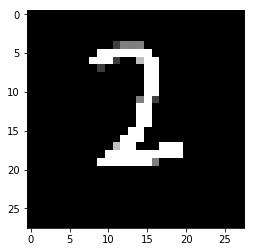

In [134]:
input_data = get_image_orig()
print('Prediction: ',session.run(y_pred_cls, feed_dict = {x: input_data}))

In [124]:
tf.all_variables()

[<tf.Variable 'Variable:0' shape=(5, 5, 1, 16) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(5, 5, 16, 36) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(36,) dtype=float32_ref>,
 <tf.Variable 'Variable_4:0' shape=(1764, 128) dtype=float32_ref>,
 <tf.Variable 'Variable_5:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Variable_6:0' shape=(128, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_7:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'Variable/Adam:0' shape=(5, 5, 1, 16) dtype=float32_ref>,
 <tf.Variable 'Variable/Adam_1:0' shape=(5, 5, 1, 16) dtype=float32_ref>,
 <tf.Variable 'Variable_1/Adam:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'Variable_1/Adam_1:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'Variable_2/Adam:0' shape=(5, 5, 16, 36) dtype=float32_ref>,
 <tf.Variable

In [127]:
saver.restore(sess=session, save_path=save_path)

INFO:tensorflow:Restoring parameters from weights_biases/CNN_mnist
